In [1]:
import os
import cv2 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from google.colab.patches import cv2_imshow 


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
drive_path = "/content/drive/MyDrive/dataset/image"
file_path = []
for dirname, _, filenames in os.walk(drive_path):
    print(filenames)
    for i in range(len(filenames)):
        if ".png" in filenames[i]:
            file_path.append(drive_path + "/" + filenames[i])

['0.png', '1.png', '2.png', 'audrey01.jpg']


In [4]:
for i in range(len(file_path)):
    print(file_path[i])
    image = cv2.cvtColor(cv2.imread(file_path[i]), cv2.COLOR_BGR2RGB)

/content/drive/MyDrive/dataset/image/0.png
/content/drive/MyDrive/dataset/image/1.png
/content/drive/MyDrive/dataset/image/2.png


In [6]:
# image size
width_size = 256 
hight_size = 256 
channel_size = 3 
img_size = (width_size, hight_size, channel_size)

cell_num = 3 
class_num = 3 
anchor_num = 1 
label_num = anchor_num * (5 + class_num)

epoch_num = 20000

loss_p_rate =1.0 
loss_cod_rate = 5.0
loss_c_rate = 1.0 
loss_p_no_rate = 0.5 

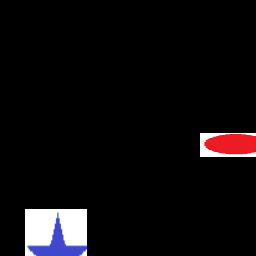

In [7]:
def get_make_image_label():
    images = np.zeros((hight_size+400,
                       width_size+400,
                       channel_size))
    label = np.zeros((cell_num, cell_num, label_num))

    num_shape = np.random.randint(1, 4)
    i = np.random.choice(range(cell_num), num_shape, replace=False)
    j = np.random.choice(range(cell_num), num_shape, replace=False)
    
    img_0 = cv2.imread(file_path[0])
    img_1 = cv2.imread(file_path[1])
    img_2 = cv2.imread(file_path[2])

    for n_h in range(num_shape):
        row = i[n_h]
        col = j[n_h]
        shape_type = np.random.randint(0, class_num)
        x_rate = np.random.rand()
        y_rate = np.random.rand()
        w_rate = np.random.rand() * 0.3 + 0.1
        h_rate = np.random.rand() * 0.3 + 0.1

        label[row, col] = [1, x_rate, y_rate, w_rate, h_rate, 0, 0, 0 ]
        label[row, col, 5+shape_type ] = 1

        x = int(x_rate * width_size/cell_num + col * width_size/cell_num)
        y = int(y_rate * hight_size/cell_num + row * hight_size/cell_num)
        w = int(w_rate * width_size/2) * 2
        h = int(h_rate * hight_size/2) * 2

        if(shape_type==0):
            input_img = cv2.resize(img_0,(w,h))
        if(shape_type==1):
            input_img = cv2.resize(img_1,(w,h))
        if(shape_type==2):
            input_img = cv2.resize(img_2,(w,h))

        images[y-int(h/2)+200 : y+int(h/2)+200, x-int(w/2)+200 : x+int(w/2)+200] =input_img
    images = images[200:200+hight_size,200:200+width_size]        
    
    return images,label

img,label = get_make_image_label()
cv2_imshow(img)

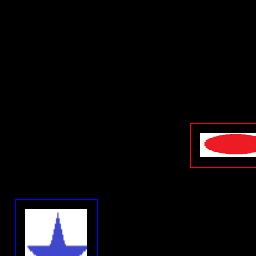

In [8]:
def set_show_box(img,label,th=0.3):
    b_img = np.zeros((hight_size+400,width_size+400,3))
    b_img[200:200+hight_size,200:200+width_size] = img
    for i in range(cell_num):
        for j in range(cell_num):
            if(label[i,j,0] > th):
                x_rate = label[i,j,1]
                y_rate = label[i,j,2]
                w_rate = label[i,j,3]
                h_rate = label[i,j,4]
                shape_type=np.argmax(label[i,j,5:])
                if(shape_type==0):
                    line_color = [0,0,255]
                if(shape_type==1):
                    line_color = [255,0,0]
                if(shape_type==2):
                    line_color = [0,255,0]
                x = int(x_rate * width_size/3 + j * width_size/3)
                y = int(y_rate * hight_size/3 + i * hight_size/3)
                w = int(w_rate * width_size/2) * 2 + 20
                h = int(h_rate * hight_size/2) * 2 + 20

                cv2.rectangle(b_img,(x-int(w/2)+200,y-int(h/2)+200),(x+int(w/2)+200,y+int(h/2)+200),line_color)
                
    b_img = b_img[200:200+hight_size,200:200+width_size]

    return b_img

cv2_imshow(set_show_box(img,label))

In [9]:

vgg_model = tf.keras.applications.VGG16(include_top=False,input_shape=img_size)
vgg_model.trainable=False

i=tf.keras.Input(shape=img_size)
out=tf.keras.layers.Lambda((lambda x : x/255.))(i)
out = vgg_model(out)
out = tf.keras.layers.Conv2D(256,3,padding='same')(out)
out = tf.keras.layers.Conv2D(128,3,padding='same')(out)
out = tf.keras.layers.Conv2D(64,3,padding='same')(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dense(1024,activation='relu')(out)
out = tf.keras.layers.Dense(3*3*8,activation='sigmoid')(out)
out = tf.keras.layers.Reshape((3,3,8))(out)

yolo_model = tf.keras.Model(inputs=[i],outputs=[out])
opt = tf.keras.optimizers.Adam(0.00001)

# 모델 요약
yolo_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          73792     
                                                              

In [ ]:

fcc=cv2.VideoWriter_fourcc(*'DIVX')
out=cv2.VideoWriter('hjk_yolo.avi',fcc,1.0,(width_size,hight_size))


for e in range(epoch_num):
    img,label = get_make_image_label()
    img = np.reshape(img,(1,hight_size,width_size,3))
    label = np.reshape(label,(1,3,3,8))
    loss_p_list=[]
    loss_cod_list = []
    loss_c_list = []
    loss_p_no_list = []
    with tf.GradientTape() as tape:
        pred = yolo_model(img)

        for i in range(3):
            for j in range(3):

                if(label[0,i,j,0]==1):
                    loss_p_list.append(tf.square(label[0,i,j,0]-pred[0,i,j,0]))
                    loss_cod_list.append(tf.square(label[0,i,j,1]-pred[0,i,j,1]))
                    loss_cod_list.append(tf.square(label[0,i,j,2]-pred[0,i,j,2]))
                    loss_cod_list.append(tf.square(label[0,i,j,3]-pred[0,i,j,3]))
                    loss_cod_list.append(tf.square(label[0,i,j,4]-pred[0,i,j,4]))
                    loss_c_list.append(tf.square(label[0,i,j,5]-pred[0,i,j,5]))
                    loss_c_list.append(tf.square(label[0,i,j,6]-pred[0,i,j,6]))
                    loss_c_list.append(tf.square(label[0,i,j,7]-pred[0,i,j,7]))

                else:
                    loss_p_no_list.append(tf.square(label[0,i,j,0]-pred[0,i,j,0]))
        loss_p=tf.reduce_mean(loss_p_list)
        loss_cod =tf.reduce_mean(loss_cod_list)
        loss_c = tf.reduce_mean(loss_c_list)
        loss_p_no = tf.reduce_mean(loss_p_no_list)

        loss = loss_p_rate * loss_p + loss_cod_rate * loss_cod + loss_c_rate * loss_c + loss_p_no_rate * loss_p_no

    vars = yolo_model.trainable_variables
    grad = tape.gradient(loss, vars)
    opt.apply_gradients(zip(grad, vars))

    if(e%100==0):
        img = np.reshape(img,(256,256,3))
        label = pred.numpy()
        label = np.reshape(label,(3,3,8))
        sample_img = np.uint8(set_show_box(img,label))
        out.write(sample_img)
    print(e,"완료",loss.numpy())    
out.release()